In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
from scipy import stats
from scipy import constants as con

In [ ]:
data=[np.array([ 5.  ,  5.25,  5.5 ,  5.75,  6.  ,  6.25,  6.5 ,  6.75,  7.  ,
        7.25,  7.5 ,  7.75,  8.  ,  8.25,  8.5 ,  8.75,  9.  ,  9.25,
        9.5 ,  9.75, 10.  ]), np.array([1.5952070e-12, 1.8842550e-12, 2.1581560e-12, 2.3263215e-12,
       2.7216130e-12, 3.0765775e-12, 3.2452565e-12, 3.6013460e-12,
       3.7502705e-12, 4.1556945e-12, 4.3065635e-12, 4.6594800e-12,
       4.9800525e-12, 5.1488320e-12, 5.4560990e-12, 5.7530275e-12,
       5.9682780e-12, 6.1725745e-12, 6.5307115e-12, 6.5909975e-12,
       6.8783055e-12]), np.array([7.0086840e-06, 7.4273925e-06, 7.8785165e-06, 8.0511650e-06,
       8.4188435e-06, 8.9054880e-06, 9.1151490e-06, 9.4644115e-06,
       9.6490780e-06, 1.0087590e-05, 1.0474480e-05, 1.0715855e-05,
       1.0960095e-05, 1.1438850e-05, 1.1674585e-05, 1.1916855e-05,
       1.2441170e-05, 1.2770135e-05, 1.2719125e-05, 1.3027085e-05,
       1.3517020e-05])]
#convert SiPM to milliAmps
data[2]*=1000

In [5]:
voltage=np.linspace(3.86,9,7)
f=[90,100,115]
#data=-np.array([[1.6771050000000014e-14, 2.7367490000000004e-13, -3.20994e-13, -3.2559980000000003e-13, -1.265249e-13, -5.441248000000001e-13, -1.5400250000000002e-12, -1.6372615e-12], [-1.986817e-13, -2.462765e-13, -6.1935375e-13, -1.5113645e-12, -3.744205e-12, -4.1050005e-12, -4.8378504999999995e-12, -5.567122e-12], [2.2454730000000002e-13, -3.3557724999999998e-12, -1.1538414999999999e-11, -2.0922185e-11, -3.0512685e-11, -4.050189e-11, -4.749366e-11, -5.5808794999999995e-11], [-6.3214745e-13, -4.4576034999999995e-12, -1.720828e-11, -3.12532e-11, -4.5123605e-11, -5.815676e-11, -7.082401999999999e-11, -8.216574000000001e-11], [-7.708358999999999e-13, -5.528731e-12, -2.2159605e-11, -4.0254665e-11, -5.771972e-11, -7.470987e-11, -9.035554499999999e-11, -1.0574595e-10]])
data=-np.array([[-2.4197525e-12, -9.814697e-12, -1.8168655e-11, -2.6548805e-11, -3.4564119999999995e-11, -4.2139990000000003e-11, -4.9495049999999996e-11], [-2.6220919999999997e-12, -1.0813630000000001e-11, -2.025611e-11, -2.9420165e-11, -3.813329e-11, -4.671438e-11, -5.4709635e-11], [-3.0815625000000003e-12, -1.2496125e-11, -2.3017915e-11, -3.3493825e-11, -4.3819885e-11, -5.3305545e-11, -6.2751315e-11]])
data_t=np.transpose(data)

m: 2.6800739473684228e-14, c: -1.693951315789722e-14
m: 1.0764468947368417e-13, c: 9.760723684210914e-14
m: 1.9319276315789473e-13, c: 8.396290789473677e-13
m: 2.7730947368421036e-13, c: 1.6278018421052794e-12
m: 3.709313157894739e-13, c: 1.1277478947368201e-12
m: 4.4605289473684203e-13, c: 2.037927368421061e-12
m: 5.307133421052635e-13, c: 1.6961435526315423e-12


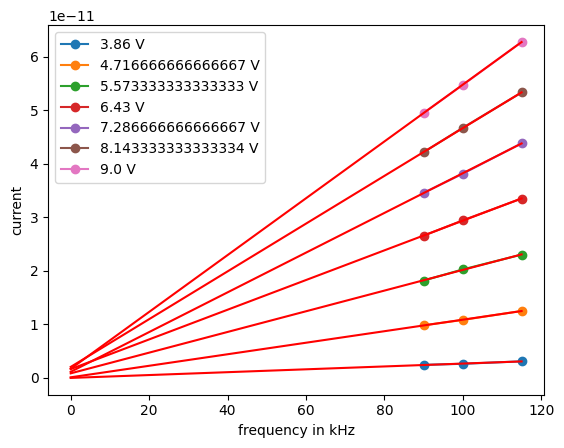

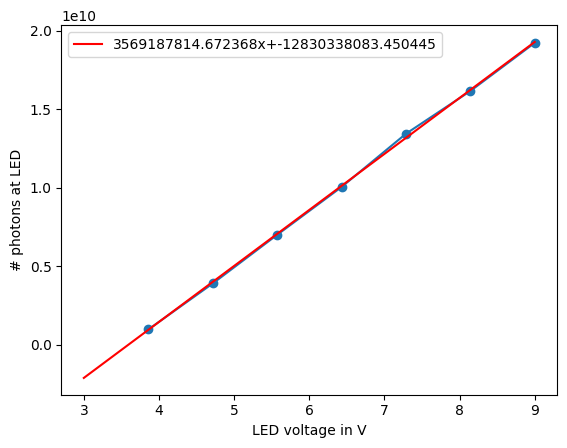

In [ ]:
#Current vs frequency
m_V=[]
for i in range(len(voltage)):
    plt.plot(f,data_t[i],marker="o",label=f"{voltage[i]} V")

    #fit
    coeffs = stats.linregress(f[-3:], data_t[i][-3:])
    m=coeffs.slope
    c=coeffs.intercept
    print(f"m: {m}, c: {c}")
    #y_fit=m*np.array(f)+c
    #plt.plot(f,y_fit,color="red")
    f_fit = np.linspace(0, max(f), 100)  # extend fit from 0 to max(f)
    y_fit = m * f_fit + c
    plt.plot(f_fit,y_fit,color="red")
    m_V.append(m)
plt.legend()
plt.xlabel("frequency in kHz")
plt.ylabel("current")
#plt.xlim(0,12)
#plt.ylim(0,1e-11)
plt.show()   

#Number photons vs voltage
R=0.1401
l=365e-9
#t=42e-9
geo=8*(210/11.3)**2
photons=np.array(m_V)*l*geo/(R*con.c*con.h)
coeff2 = np.polyfit(voltage[2:], photons[2:], 1)
m, c = coeff2
v_fit=np.linspace(3, max(voltage),100)
N_fit=m*v_fit+c
plt.plot(voltage,photons,marker="o")
plt.plot(v_fit,N_fit,color="red",label=f"{m}x+{c}")
plt.xlabel("LED voltage in V")
plt.ylabel("# photons at LED")
plt.legend()
plt.show()


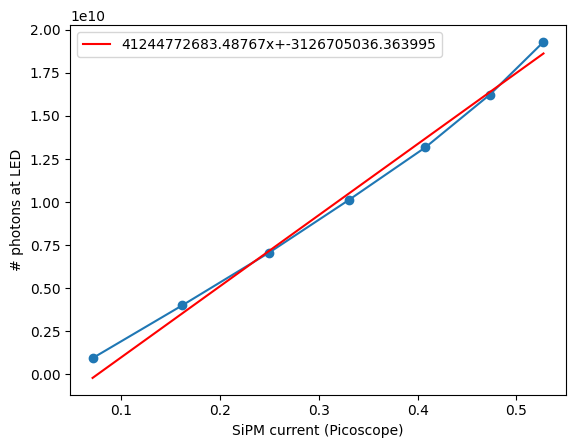

In [7]:
#SiPM current vs Photons with Picoscope
#current = np.array([0.022157479858398443, 0.07527559105396273, 0.16724409387588504, 0.2571338583946228, 0.3406141726875306, 0.41514960868835465, 0.48250393653869644, 0.539007871246338])
current = np.array([0.07097637817382813, 0.16157480245590214, 0.2494173239135743, 0.33020472288131714, 0.4078425223159792, 0.47302362312316903, 0.5273070835876467])

coeff3 = np.polyfit(current[1:], N_fit[1:], 1)
m, c = coeff3
N_curr=m*current+c

plt.plot(current, N_fit, marker="o")
plt.plot(current,N_curr,color="red", label=f"{m}x+{c}")
plt.ylabel("# photons at LED")
plt.xlabel("SiPM current (Picoscope)")
plt.legend()
plt.show()

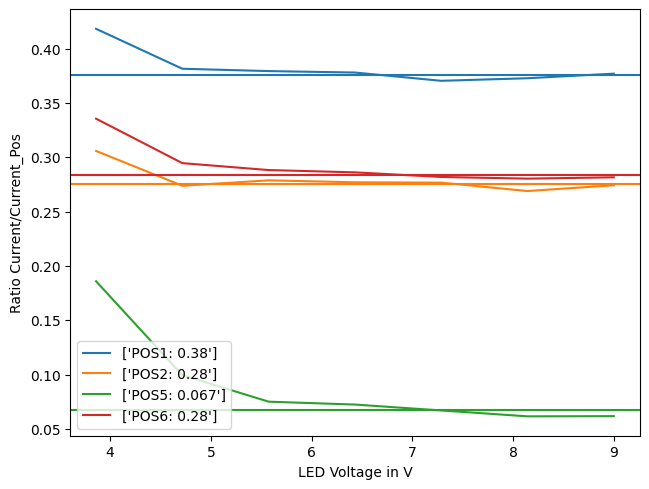

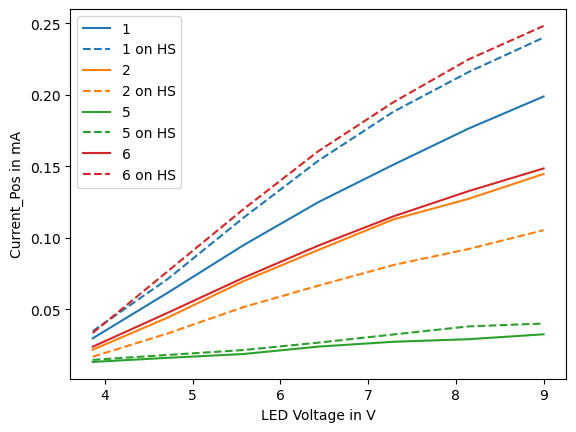

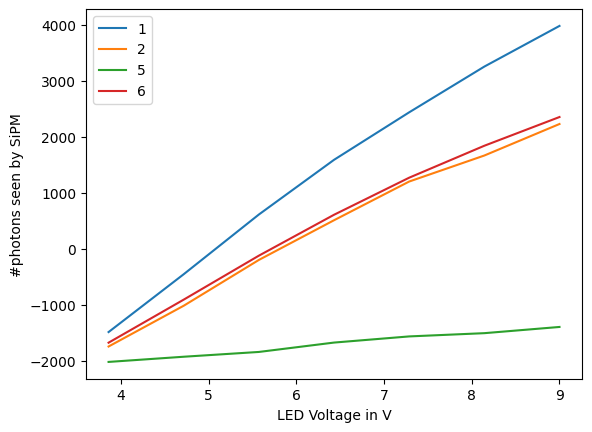

In [10]:
#positions
color=["tab:blue","tab:orange","tab:green","tab:red","purple"]
pos=[1,2,5,6]
#current_pos=np.array([[0.010661417081356053, 0.011921259572505952, 0.014125983932018284, 0.015511810672283176, 0.014598424866199496, 0.015212598080635074, 0.016897637412548072, 0.017669290938377387], [0.011763779261112215, 0.02820472398757935, 0.057795275571346304, 0.0855118123674393, 0.1124094502449036, 0.14062992073059086, 0.16031495985984803, 0.18154330716133124], [0.015055117769241337, 0.028393700397014627, 0.0632440944337845, 0.10045669490337375, 0.1299370077800751, 0.1605669283103943, 0.18355905533790592, 0.20377952949523934], [0.013307086312770845, 0.024472440485954292, 0.04760629937887194, 0.07267716560840609, 0.0960314979553223, 0.11965354408264163, 0.13595275521278385, 0.15270866055488588], [0.009055117905139924, 0.014440944554805761, 0.01752755865812302, 0.021196849954128273, 0.025133857817649846, 0.030409448456764233, 0.03338582652330399, 0.03845669296026231]])
current_pos=np.array([[0.029700787003040317, 0.06166929132938387, 0.09466141928195955, 0.12488189015388493, 0.15113385736465457, 0.1764094487190247, 0.19888189152717595], [0.02171653499126435, 0.04425196868658067, 0.06955905524253848, 0.09149606468200686, 0.11288189107894903, 0.12725984265327459, 0.14467716456413274], [0.01319685009479523, 0.016062991764545443, 0.01870866099596024, 0.023889763295650488, 0.027291338152885446, 0.029086613836288456, 0.03251968481063844], [0.023826771192550666, 0.04762204743146897, 0.07192125998020174, 0.09451968694210054, 0.11500787513732914, 0.1326614170646668, 0.14853543249130252]])
current_pos1=np.array([[0.03472440930604936, 0.07127559079170229, 0.11381102490425113, 0.15385826669692995, 0.18817322919845583, 0.2159370102596284, 0.2400944899177552], [0.016834645290374758, 0.03314960608482362, 0.05144881905555727, 0.06651968506097794, 0.08096063082218172, 0.09218897807121279, 0.1053700804805756], [0.01464566895961762, 0.018078739755153662, 0.02149606254816056, 0.02666141688108445, 0.03239370058298111, 0.03803149610042573, 0.04004724417686463], [0.03343307069301606, 0.07669291393280031, 0.11979527655601505, 0.16051968423843385, 0.19483464665412908, 0.22477165575027475, 0.2482362212562562]])


for i in range(len(pos)):
    
    ratio=current_pos[i]/current
    avg=np.mean(ratio[2:])
    plt.plot(voltage,ratio,color=color[i])
    plt.axhline(avg, label=[f"POS{pos[i]}: {avg:.02}"],color=color[i])
plt.legend()
plt.tight_layout()
plt.xlabel("LED Voltage in V")
plt.ylabel("Ratio Current/Current_Pos")
plt.show()
for i in range(len(pos)):
    plt.plot(voltage,current_pos[i],label=pos[i],color=color[i])
    plt.plot(voltage,current_pos1[i],label=f"{pos[i]} on HS", linestyle='--',color=color[i])
plt.xlabel("LED Voltage in V")
plt.ylabel("Current_Pos in mA")
plt.legend()
plt.show()



current_pos1=[]
geo2=6.07**2/4*np.pi*210**2
for i in range(len(pos)):
    #current_pos1.append(np.delete(current_pos[i], 0))
    N_pos=((m*current_pos[i]+c)/geo2)
    plt.plot(voltage,N_pos,label=pos[i])
plt.xlabel("LED Voltage in V")
plt.ylabel("#photons seen by SiPM")
plt.legend()
plt.show()

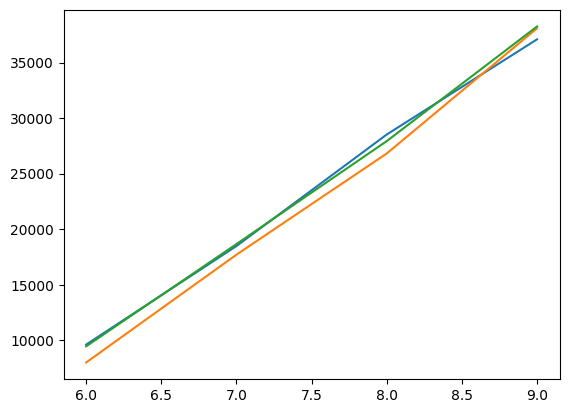

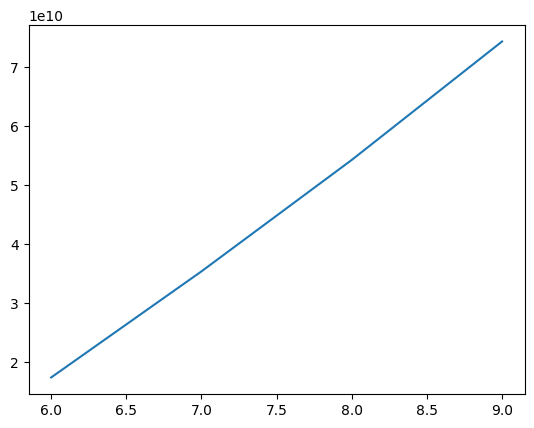

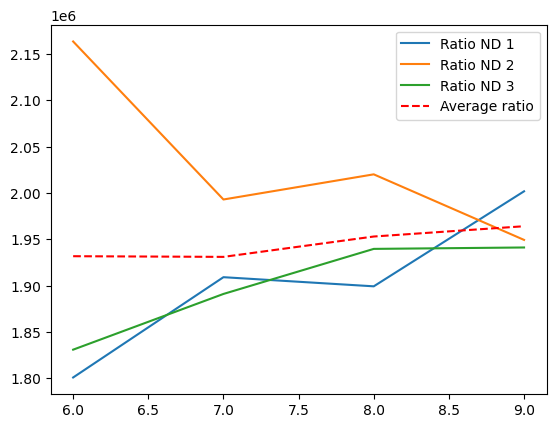

In [ ]:
#Ind1=-np.array([-9.545793000000002e-13, -1.5085955e-12, -4.166849e-12, -6.388528e-12, -8.633189e-12])
'''
I=-np.array([[-1.5856301e-13, -1.3764044999999998e-12, -2.7555614999999997e-12, -4.1650165e-12, -5.973459e-12],           #with ND at pos1
            [-1.0035509999999999e-07, -6.1917565e-07, -1.138931e-06, -1.6593805e-06, -2.3175085e-06],                    #without
            [-2.2276045e-12, -1.4602345e-11, -2.9175215e-11, -4.4886290000000003e-11, -6.17364e-11]])                    #with ND at pos2
'''

I=-np.array([[-1.5459695e-06, -3.1516205e-06, -4.8386235e-06, -6.631253e-06],
             [ -8.584080500000001e-13, -1.6507785e-12, -2.547555e-12, -3.31259e-12],
             [-7.145748e-13, -1.581345e-12, -2.395197e-12, -3.4016855e-12],
             [-8.4434025e-13, -1.6665595e-12, -2.49451e-12, -3.4160125e-12],
             ])
v_2=np.linspace(6,9,4)
R=0.1821
l=405e-9
freq=1000
photons=[]
#calculate number of photons from current
for i in range(len(I)):
    photons.append(I[i]*l/(R*con.c*con.h*freq))
    
for i in range(len(I)-1):
    plt.plot(v_2,photons[i+1])
plt.show()
plt.plot(v_2,photons[0])
plt.show()
ratios = []
for i in range(1, len(I)):
    ratio = I[0] / I[i]
    ratios.append(ratio)
    plt.plot(v_2, ratio, label=f'Ratio run {i}')

# Calculate and plot the average ratio
ratios = np.array(ratios)
avg_ratio = np.mean(ratios, axis=0)
plt.plot(v_2, avg_ratio, color='red', linestyle='--', label='Average ratio')

plt.legend()
plt.show()
